#### 从数据库导入数据

In [34]:
import pymysql.cursors
import pandas as pd

db = pymysql.connect(host='localhost',user='root',password='root',db='lagou',charset='utf8',cursorclass=pymysql.cursors.DictCursor)
cursor = db.cursor()
sql = 'SELECT * FROM dataset;'
cursor.execute(sql)
result = cursor.fetchall()
df = pd.DataFrame(list(result))
db.close()

df

,jobNature,companySize,workYear,education,industryField,thirdType,salaryMin,salaryMax,nameUnfit,positionId,...,financeStage,firstType,secondType,district,salary,resumeProcessRate,resumeProcessDay,score,famousCompany,isFocus
0,全职,500-2000人,1-3年,本科,旅游,数据分析,18,35,0,6112946,...,D轮及以上,开发|测试|运维类,数据开发,福田区,18k-35k,100,1,199,0,1
1,全职,500-2000人,3-5年,本科,"消费生活,移动互联网",商业,15,25,0,6229664,...,C轮,产品|需求|项目类,数据分析,南山区,15k-25k,100,1,179,0,1
2,全职,2000人以上,5-10年,本科,金融,建模,15,30,0,6853427,...,上市公司,开发|测试|运维类,数据开发,福田区,15k-30k,100,1,130,1,0
3,全职,2000人以上,1-3年,本科,金融,Hadoop,20,30,0,6692363,...,不需要融资,开发|测试|运维类,数据开发,南山区,20k-30k,100,2,89,0,0
4,全职,2000人以上,1-3年,大专,"移动互联网,游戏",数据分析,8,10,0,6835783,...,不需要融资,产品|需求|项目类,数据分析,南山区,8k-10k,0,1,69,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,全职,2000人以上,3-5年,本科,社交,产品经理,15,25,1,5276304,...,上市公司,产品|需求|项目类,产品经理,南山区,15k-25k,100,1,10,1,0
271,全职,2000人以上,3-5年,本科,社交,数据挖掘,18,35,0,6842800,...,上市公司,开发|测试|运维类,数据开发,南山区,18k-35k,100,1,10,1,1
272,全职,2000人以上,3-5年,本科,社交,数据分析,20,40,0,5250466,...,上市公司,产品|需求|项目类,数据分析,南山区,20k-40k,100,1,10,1,1
273,全职,2000人以上,1-3年,本科,金融,数据分析,20,30,0,6391267,...,未融资,开发|测试|运维类,数据开发,南山区,20k-30k,15,1,4,1,0


#### 拆分训练集和测试集

In [35]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
X = pd.get_dummies(X).values
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
X_names = pd.get_dummies(df.iloc[:,:-1]).columns
X_names

Index(['salaryMin', 'salaryMax', 'nameUnfit', 'resumeProcessRate',
       'resumeProcessDay', 'score', 'famousCompany', 'jobNature_全职',
       'jobNature_兼职', 'jobNature_实习',
       ...
       'salary_7k-13k', 'salary_7k-14k', 'salary_8k-10k', 'salary_8k-11k',
       'salary_8k-12k', 'salary_8k-13k', 'salary_8k-15k', 'salary_8k-16k',
       'salary_9k-12k', 'salary_9k-14k'],
      dtype='object', length=687)

#### 网格搜索（含交叉验证）——找出最优参数

In [8]:
?GridSearchCV

In [9]:
?LogisticRegression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression()
parameters = {
    'random_state':[0],
    #'penalty':['l1', 'l2', 'elasticnet'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class':['ovr', 'auto'],
    'max_iter':[10000],
    'n_jobs':[-1]
}
scorings = ['neg_mean_squared_error','neg_mean_absolute_error']
for scoring in scorings:
    print('===========================================================================')
    print('此次调参的scoring为：%s' % scoring)
    print()
    clf = GridSearchCV(lr, parameters, scoring=scoring, cv=10)
    clf.fit(X_train, y_train)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    print('【交叉验证】过程如下：')
    for mean, std, param in zip(means, stds, params):
        print('%s得分为 %0.3f(+-%0.3f)时，参数为：%r' % (scoring, mean, std * 2, param))
    print()
    print('【训练集】最佳参数为：%r' % clf.best_params_)
    print('【训练集】最佳参数得分为：%0.3f' % clf.best_score_)
    print()
    print('【测试集】%s得分为：%0.3f' % (scoring, clf.score(X_test, y_test)))    # 直接获取测试集的得分
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    reports = classification_report(y_true, y_pred)
    print('【测试集中实际值与预测值对比】模型报告如下：')
    print(reports)

此次调参的scoring为：neg_mean_squared_error



C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packag

【交叉验证】过程如下：
neg_mean_squared_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'newton-cg'}
neg_mean_squared_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'lbfgs'}
neg_mean_squared_error得分为 -0.082(+-0.125)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'liblinear'}
neg_mean_squared_error得分为 -0.098(+-0.109)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'sag'}
neg_mean_squared_error得分为 -0.104(+-0.127)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'saga'}
neg_mean_squared_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': -1, 'random_state': 0, 'solver': 'newton-cg'}
neg_mean_squared_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': -1, 'random_state': 0, 'solver':

C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\romak\Anaconda3\lib\site-packag

【交叉验证】过程如下：
neg_mean_absolute_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'newton-cg'}
neg_mean_absolute_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'lbfgs'}
neg_mean_absolute_error得分为 -0.082(+-0.125)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'liblinear'}
neg_mean_absolute_error得分为 -0.098(+-0.109)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'sag'}
neg_mean_absolute_error得分为 -0.104(+-0.127)时，参数为：{'max_iter': 10000, 'multi_class': 'ovr', 'n_jobs': -1, 'random_state': 0, 'solver': 'saga'}
neg_mean_absolute_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': -1, 'random_state': 0, 'solver': 'newton-cg'}
neg_mean_absolute_error得分为 -0.093(+-0.131)时，参数为：{'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': -1, 'random_state': 0, 's

C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


### 一、根据最优参数建模

In [60]:
?LogisticRegression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', max_iter=10000, n_jobs=-1)
lr.fit(X_train, y_train)
print('【测试集】mean accuracy：%0.3f' % (lr.score(X_test, y_test)))    # 直接获取测试集的得分
print()
y_true, y_pred = y_test, lr.predict(X_test)
reports = classification_report(y_true, y_pred)
print('【测试集中实际值与预测值对比】模型报告如下：')
print(reports)

【测试集】mean accuracy：0.835

【测试集中实际值与预测值对比】模型报告如下：
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        67
           1       0.76      0.54      0.63        24

    accuracy                           0.84        91
   macro avg       0.81      0.74      0.76        91
weighted avg       0.83      0.84      0.83        91



C:\Users\romak\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


### 二、根据最有参数建模（含cross_validation）

In [40]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(random_state=0, multi_class='ovr', solver='liblinear', max_iter=10000, n_jobs=-1)
lrcv.fit(X_train, y_train)
print('LogisticRegressionCV得分为：%0.3f' % lrcv.score(X_test, y_test))
print()

LogisticRegressionCV得分为：0.857



#### 模型属性

In [38]:
print('所有分类：%s' % lr.classes_)
print()
print('系数为：%r' % lr.intercept_)
print()
print('截距为：%r' % lr.coef_)

所有分类：[0 1]

系数为：array([-0.99482807])

截距为：array([[ 1.01790022e-02,  3.21772531e-02, -1.99555644e+00,
        -9.06522531e-04, -5.07779556e-01,  1.80065092e-02,
         4.96826681e-01, -7.69472834e-01, -1.59284297e-02,
        -2.09426803e-01, -2.89724153e-01,  9.38216961e-01,
        -1.13287488e-01, -1.09997834e+00, -2.69129463e-01,
        -1.60925581e-01,  1.54429243e-01, -2.40987873e-01,
         1.35845222e+00, -1.51146978e+00, -4.61497732e-01,
        -2.93754139e-01, -1.23504549e-01, -5.28894165e-01,
         4.99991447e-02, -3.92428498e-01, -1.37406283e-01,
         2.74862096e-01,  1.78549161e-01,  0.00000000e+00,
        -1.29921927e-01, -3.09855903e-01, -8.49181506e-03,
        -2.25532998e-02,  2.53571626e-01,  1.76998598e-01,
        -1.84859585e-02, -1.77389993e-01, -1.56011831e-02,
        -1.74630155e-01, -1.47881392e-01, -2.58298762e-02,
        -6.75214327e-02, -2.40616363e-01,  5.33945668e-02,
         1.49553096e-01,  2.88290014e-01,  2.25989157e-01,
        -5.332

#### 对数据进行预测

预测分类结果

In [59]:
?lr.predict

In [17]:
lr.predict(X_test)

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1], dtype=int64)

预测分类得分

In [26]:
print('所有分类：%r' % lr.classes_)
lr.predict_proba(X_test[:10,:])    # 只预测前十行

所有分类：array([0, 1], dtype=int64)


array([[0.75425234, 0.24574766],
       [0.11172083, 0.88827917],
       [0.15157399, 0.84842601],
       [0.99595051, 0.00404949],
       [0.97692694, 0.02307306],
       [0.95213647, 0.04786353],
       [0.96331192, 0.03668808],
       [0.28833022, 0.71166978],
       [0.95912161, 0.04087839],
       [0.40513476, 0.59486524]])

官方文档支出，各分类的预测概率排序，跟classes_的排序一致。因此可据此选择指定分类的概率。

In [58]:
lr.predict_proba(X_test[:10,:])[:,1:2]    # 提取预测为1的概率

array([[0.24574766],
       [0.88827917],
       [0.84842601],
       [0.00404949],
       [0.02307306],
       [0.04786353],
       [0.03668808],
       [0.71166978],
       [0.04087839],
       [0.59486524]])

#### 调整预测分类的阈值

借助Series

In [116]:
import pandas as pd
import numpy as np

predict_proba = lr.predict_proba(X_test)[:,1:2]
result = map(lambda x: 1 if x>0.7 else 0, predict_proba)
series = pd.Series(result)
np.array(series)

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

借助DataFrame

In [97]:
predict_proba = lr.predict_proba(X_test)[:,1:2]

df_result = pd.DataFrame(predict_proba, columns=['class_one_proba'])
df_result['result'] = df_result['class_one_proba'].map(lambda x: 1 if x>0.7 else 0)
df_result

,class_one_proba,result
0,0.245748,0
1,0.888279,1
2,0.848426,1
3,0.004049,0
4,0.023073,0
...,...,...
86,0.072698,0
87,0.257294,0
88,0.029853,0
89,0.023610,0


#### 画ROC曲线图

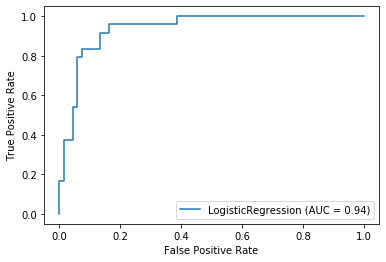

In [14]:
from sklearn.metrics import plot_roc_curve
from matplotlib import pyplot as plt

plot_roc_curve(lr, X_test, y_test)
plt.show()